In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [7]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [9]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [10]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
y_pred_small

array([0.0162059 , 0.5851175 , 0.58502842, ..., 0.33555371, 0.60117704,
       0.58919853])

In [11]:
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

### 4.2 Accuracy and Dummy Model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [12]:
# accuracy tells the fraction of our correct predictions
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

np.float64(0.8055358410220014)

In [13]:
# number of customers
len(y_val)

1409

In [14]:
# number of correct prediction

(y_val == churn_decision).sum()

np.int64(1135)

In [15]:
# accuracy = (number of correct prediction) / (number of customers) 

accuracy = (y_val == churn_decision).sum() / len(y_val)
accuracy



np.float64(0.8055358410220014)

In [16]:
# find out if the 0.5 decision threshold is ideal by moving the threshold
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [17]:
# loop through the thresholds
thresholds = np.linspace(0, 1, 21)

# define a list to hold the score
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean() # using custom implementation
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [18]:
# view the scores
scores

[np.float64(0.2739531582682754),
 np.float64(0.5081618168914124),
 np.float64(0.6053938963804116),
 np.float64(0.6635911994322214),
 np.float64(0.7047551454932577),
 np.float64(0.7381121362668559),
 np.float64(0.759403832505323),
 np.float64(0.7665010645848119),
 np.float64(0.7806955287437899),
 np.float64(0.7927608232789212),
 np.float64(0.8055358410220014),
 np.float64(0.8041163946061036),
 np.float64(0.7998580553584103),
 np.float64(0.78708303761533),
 np.float64(0.765791341376863),
 np.float64(0.7423704755145494),
 np.float64(0.7288857345635202),
 np.float64(0.7260468417317246),
 np.float64(0.7260468417317246),
 np.float64(0.7260468417317246),
 np.float64(0.7260468417317246)]

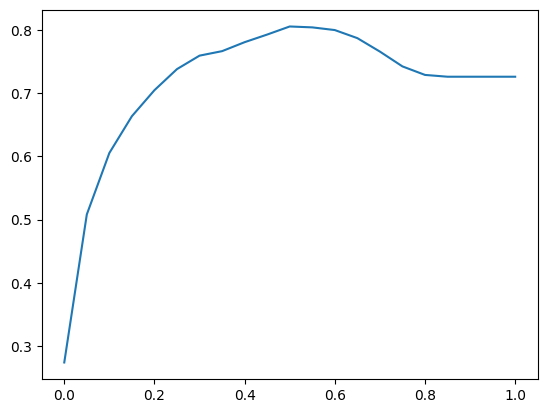

In [19]:
# plot the scores against the thresholds
plt.plot(thresholds, scores)

In [20]:
# using package from sklearn.metrics to ascertain the accuracy
from sklearn.metrics import accuracy_score

In [21]:
# pass the actual values and predictions as parameters to sklearn accuracy_score
accuracy_score(y_val, y_pred >= 0.5)

0.8055358410220014

In [22]:
# loop through the thresholds
thresholds = np.linspace(0, 1, 21)

# define a list to hold the score
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t) # using sklearn accuracy_score now
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [23]:
# customers are churning if score is greater than 1.0
# the curve above represent the cases for when customers are not churning, hence, all predicted values for churning are false
y_pred >= 1.0

array([False, False, False, ..., False, False, False])

In [24]:
# count all false values and true values in our prediction
from collections import Counter

In [25]:
# NOTE that the dummy model is predicting all customers as non-churning
count_false_values = Counter(y_pred >= 1.0)
count_false_values

Counter({np.False_: 1409})

In [26]:
# CLASS IMBALANCE: we have approximately 3x more non-churning customers than churning ones.

# accuracy isn't telling us how good the model

# Our original model's accuracy = 0.8055358410220014 computed using (churn == y_val).mean() or accuracy = (y_val == churn_decision).sum() / len(y_val)

# Our dummy model's accuracy approximates 0.73 ascertained from one of the thresholds and score values in the loop at print('%.2f %.3f' % (t, score)) = 1.00 0.726. This implies the dummy model would be accurate approximately 73% of the time, and incorrect approximate 23% of the times when customers are churning.


In [27]:
# checking the distribution of y_val indicated that there are a lot more non-churning customers (i.e. 1023) than there are churning customers (386)
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [28]:
# mean shows the approx percentages of churning and non-churning customers

churning_customers = (y_val).mean() * 100
non_churning_customers = (1 - (y_val).mean()) * 100

print(f'Percentage of Churning customers: {churning_customers:.2f}%')
print(f'Percentage of Non-churning customers: {non_churning_customers:.2f}%')

Percentage of Churning customers: 27.40%
Percentage of Non-churning customers: 72.60%


### 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table